### Stock Market Prediction And Forecasting Using Stacked LSTM

In [45]:
### Keras and Tensorflow >2.0
import tensorflow as tf

In [46]:
tf.__version__

'2.6.0'

In [62]:
import ipynb.fs.defs.backtesting_MA_Strategy as bt

In [48]:
### Data Collection
import pandas_datareader as pdr

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from sklearn.metrics import mean_squared_error

import plotly as py
import plotly.io as pio
import plotly.graph_objects as go

import datetime as dt
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.layers import LSTM

In [50]:
from scipy.optimize import minimize
import pandas_ta as pta

In [51]:
tf.random.set_seed(999)

In [52]:
### SET UP
start = dt.datetime(2020, 1, 1)
end = dt.datetime(2021, 9, 30)
alloc_start = dt.datetime(2020, 1, 1)
alloc_end = dt.datetime(2021,7,31)

tickers = ['CVLG','TEAM','FOXA','NVDA','TSLA','CROX','GIII','JBLU','CZR','NFLX']
# tickers=['TSLA']

# Weight Set-up
equal_weights = bt.equal_weight(tickers)
print('Equal weights: ', equal_weights)
minvar_weights = bt.minvar_weight(tickers, alloc_start, alloc_end)
print('Min Variance weights: ', minvar_weights)
sharpe_weights = bt.maxsharpe_weight(tickers, alloc_start, alloc_end)
print('Max Sharpe weights: ', sharpe_weights)

Equal weights:  {'CVLG': 0.1, 'TEAM': 0.1, 'FOXA': 0.1, 'NVDA': 0.1, 'TSLA': 0.1, 'CROX': 0.1, 'GIII': 0.1, 'JBLU': 0.1, 'CZR': 0.1, 'NFLX': 0.1}
     fun: 0.09170220671018887
     jac: array([0.17895045, 0.17873231, 0.17871749, 0.20773377, 0.26266249,
       0.25201477, 0.27394177, 0.17859369, 0.35410789, 0.17905985])
 message: 'Optimization terminated successfully'
    nfev: 88
     nit: 8
    njev: 8
  status: 0
 success: True
       x: array([0.06709318, 0.2669501 , 0.28816175, 0.01      , 0.01      ,
       0.01      , 0.01      , 0.02920542, 0.01      , 0.29858955])
Min Variance weights:  {'CVLG': 0.06709317707176389, 'TEAM': 0.2669501049078051, 'FOXA': 0.28816174857564375, 'NVDA': 0.009999999999999985, 'TSLA': 0.009999999999999962, 'CROX': 0.010000000000000016, 'GIII': 0.009999999999999985, 'JBLU': 0.029205420420389507, 'CZR': 0.010000000000000033, 'NFLX': 0.29858954902439794}
     fun: -4.976167075923322
     jac: array([-2.21989983, -3.4458276 ,  0.2710979 , -3.79313767, -5.06

In [53]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [54]:
# t_list = [10,12,14,16,18,20,25,30,35,40,45,50,55,60,70,80,90,100]   # for tuning the "time_step" parameter, finally settled on 60
time_step = 60

In [55]:
import copy
from plotly.graph_objs import *
tickers = ['CVLG','TEAM','FOXA','NVDA','TSLA','CROX','GIII','JBLU','CZR','NFLX']

rmse_list = {}
model_list= {}
port_df=pd.DataFrame(columns=['Date'])
port_df_val=pd.DataFrame(columns=['Date'])
flag = 1
for ticker in tickers:
    df = pdr.get_data_yahoo(ticker,start=dt.datetime(2016, 10, 31),end=dt.datetime(2021, 10, 31))
#     df = pdr.get_data_yahoo(ticker,end=dt.datetime(2021, 10, 31))
    df1 = df.reset_index()[['Date','Adj Close']]

    ##splitting dataset into train and test split
    train_data = df1['Adj Close'][df1['Date']<'2021-08-01']
    train_data = np.array(train_data).reshape(-1,1)
    ind = df1.index[df1['Date']>='2021-08-01'][0]
    ind -= time_step
    test_data = df1['Adj Close'][df1.index>=ind]
    test_data = np.array(test_data).reshape(-1,1)
    df1=np.array(df1).reshape(-1,1)
    training_size=len(train_data)

    ### LSTM are sensitive to the scale of the data. so we apply MinMax scaler 
    scaler=MinMaxScaler(feature_range=(0,1))
    train_data=scaler.fit_transform(train_data)
    test_data=scaler.transform(test_data)

    # reshape into X=t,t+1,t+2,t+3 and Y=t+4
    X_train, y_train = create_dataset(train_data, time_step)
    X_test, ytest = create_dataset(test_data, time_step)

    print("Ticker:",ticker)
    print("Train Test Shape:")
    print(X_train.shape), print(y_train.shape)
    print(X_test.shape), print(ytest.shape)

    # reshape input to be [samples, time steps, features] which is required for LSTM
    X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
    X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

    ### Create the Stacked LSTM model
    model=Sequential()
    model.add(LSTM(60,return_sequences=True,input_shape=(time_step,1)))
    model.add(LSTM(60,return_sequences=True))
    model.add(LSTM(60))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error',optimizer='adam')
    # model.summary()

    model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

    ### Lets Do the prediction and check performance metrics
    train_predict=model.predict(X_train)
    test_predict=model.predict(X_test)

    ##Transformback to original form
    train_predict=scaler.inverse_transform(train_predict)
    test_predict=scaler.inverse_transform(test_predict)

    y_train_inv=scaler.inverse_transform(y_train.reshape(-1,1))
    ytest_inv=scaler.inverse_transform(ytest.reshape(-1,1))  

    df_fin=df.reset_index()[['Date','Adj Close']]
    df_fin['train_pred']=np.nan
    df_fin.loc[time_step:len(train_predict)+time_step-1,'train_pred'] = train_predict
    df_fin['test_pred']=np.nan
    df_fin.loc[ind+time_step:, 'test_pred'] = test_predict

    ### Calculate RMSE performance metrics
    rmse_train = math.sqrt(mean_squared_error(y_train_inv,train_predict))
    print("Train Data RMSE",rmse_train)
    ### Validation Data RMSE
    rmse_val = math.sqrt(mean_squared_error(df_fin['Adj Close'][(df_fin['Date']>='2021-08-01')&(df_fin['Date']<'2021-10-01')],df_fin['test_pred'][(df_fin['Date']>='2021-08-01')&(df_fin['Date']<'2021-10-01')]))
    print("Validation Data RMSE",rmse_val)
    ### October Data RMSE
    rmse_oct = math.sqrt(mean_squared_error(df_fin['Adj Close'][df_fin['Date']>='2021-10-01'],df_fin['test_pred'][df_fin['Date']>='2021-10-01']))
    print("October Data RMSE",rmse_oct) 
    rmse_list[ticker]=[rmse_train,rmse_val,rmse_oct]
    model_list[ticker]=model


    df_test = df_fin.loc[ind+time_step:,['Date','Adj Close','test_pred']].reset_index()
    df_test['Position']=0
    df_test['TureP']=0
    for i in range(len(df_test)-1):
        df_test.loc[i,'Position'] = df_test.loc[i+1,'test_pred']-df_test.loc[i,'Adj Close']
        df_test.loc[i,'TureP'] = df_test.loc[i+1,'Adj Close']-df_test.loc[i,'Adj Close']

    df_test['Position'] = np.round((df_test['Position'].apply(np.sign) + 1)/2)
    df_test['TureP'] = np.round((df_test['TureP'].apply(np.sign) + 1)/2)

    df_test['Order'] = 0
    curr, prev = 0, 0

    for index, row in df_test.iterrows():
        curr = row['Position']
        order = curr - prev
        df_test.at[index, 'Order'] = order
        prev = curr

    if flag == 1:
        port_df['Date'] = list(df_test['Date'][df_test['Date']>='2021-10-01'])
        port_df_val['Date'] = list(df_test['Date'][df_test['Date']<'2021-10-01'])
        flag = 2

    port_df[ticker + ' Adj Close'] = list(df_test['Adj Close'][df_test['Date']>='2021-10-01'])
    port_df[ticker + ' Order'] = list(df_test['Order'][df_test['Date']>='2021-10-01'])

    port_df_val[ticker + ' Adj Close'] = list(df_test['Adj Close'][df_test['Date']<'2021-10-01'])
    port_df_val[ticker + ' Order'] = list(df_test['Order'][df_test['Date']<'2021-10-01'])

#     layout = Layout(paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(0,0,0,0)')
#     fig = go.Figure(layout=layout)
#     fig.add_trace(go.Scatter(x=df_test['Date'][df_test['Date']<'2021-10-01'],y=df_test['Adj Close'],name='Truth',marker_color='LightSkyBlue'))
#     fig.add_trace(go.Scatter(x=df_test['Date'][df_test['Date']<'2021-10-01'],y=df_test['test_pred'],name='Prediction',marker_color='Orange'))
#     fig.update_layout(xaxis=dict(showgrid=False,color='white',linecolor='white'),yaxis=dict(showgrid=False,color='white',linecolor='white'))
#     fig.show()

   

Ticker: CVLG
Train Test Shape:
(1135, 60)
(1135,)
(64, 60)
(64,)
Epoch 1/100
18/18 [==============================] - 6s 95ms/step - loss: 0.0539 - val_loss: 0.0304
Epoch 2/100
18/18 [==============================] - 1s 61ms/step - loss: 0.0095 - val_loss: 0.0164
Epoch 3/100
18/18 [==============================] - 1s 62ms/step - loss: 0.0044 - val_loss: 0.0085
Epoch 4/100
18/18 [==============================] - 1s 62ms/step - loss: 0.0032 - val_loss: 0.0092
Epoch 5/100
18/18 [==============================] - 1s 63ms/step - loss: 0.0031 - val_loss: 0.0097
Epoch 6/100
18/18 [==============================] - 1s 64ms/step - loss: 0.0030 - val_loss: 0.0090
Epoch 7/100
18/18 [==============================] - 1s 63ms/step - loss: 0.0028 - val_loss: 0.0076
Epoch 8/100
18/18 [==============================] - 1s 63ms/step - loss: 0.0028 - val_loss: 0.0075
Epoch 9/100
18/18 [==============================] - 1s 63ms/step - loss: 0.0028 - val_loss: 0.0082
Epoch 10/100
18/18 [===============

18/18 [==============================] - 1s 68ms/step - loss: 4.7856e-04 - val_loss: 0.0074
Epoch 57/100
18/18 [==============================] - 1s 69ms/step - loss: 4.7340e-04 - val_loss: 0.0029
Epoch 58/100
18/18 [==============================] - 1s 69ms/step - loss: 4.4219e-04 - val_loss: 0.0035
Epoch 59/100
18/18 [==============================] - 1s 69ms/step - loss: 4.4297e-04 - val_loss: 0.0059
Epoch 60/100
18/18 [==============================] - 1s 68ms/step - loss: 4.6319e-04 - val_loss: 0.0037
Epoch 61/100
18/18 [==============================] - 1s 69ms/step - loss: 4.3303e-04 - val_loss: 0.0035
Epoch 62/100
18/18 [==============================] - 1s 69ms/step - loss: 4.2379e-04 - val_loss: 0.0022
Epoch 63/100
18/18 [==============================] - 1s 69ms/step - loss: 4.4689e-04 - val_loss: 0.0035
Epoch 64/100
18/18 [==============================] - 1s 69ms/step - loss: 4.2095e-04 - val_loss: 0.0025
Epoch 65/100
18/18 [==============================] - 1s 69ms/step -

Epoch 14/100
18/18 [==============================] - 1s 67ms/step - loss: 8.6330e-04 - val_loss: 0.0041
Epoch 15/100
18/18 [==============================] - 1s 67ms/step - loss: 9.1948e-04 - val_loss: 0.0069
Epoch 16/100
18/18 [==============================] - 1s 67ms/step - loss: 9.0320e-04 - val_loss: 0.0057
Epoch 17/100
18/18 [==============================] - 1s 67ms/step - loss: 7.9925e-04 - val_loss: 0.0045
Epoch 18/100
18/18 [==============================] - 1s 69ms/step - loss: 8.6070e-04 - val_loss: 0.0060
Epoch 19/100
18/18 [==============================] - 1s 67ms/step - loss: 7.8196e-04 - val_loss: 0.0064
Epoch 20/100
18/18 [==============================] - 1s 67ms/step - loss: 7.3540e-04 - val_loss: 0.0041
Epoch 21/100
18/18 [==============================] - 1s 67ms/step - loss: 7.5812e-04 - val_loss: 0.0036
Epoch 22/100
18/18 [==============================] - 1s 67ms/step - loss: 6.7019e-04 - val_loss: 0.0038
Epoch 23/100
18/18 [==============================] - 1

Epoch 68/100
18/18 [==============================] - 1s 67ms/step - loss: 3.8416e-04 - val_loss: 0.0018
Epoch 69/100
18/18 [==============================] - 1s 67ms/step - loss: 3.8143e-04 - val_loss: 0.0011
Epoch 70/100
18/18 [==============================] - 1s 67ms/step - loss: 4.1246e-04 - val_loss: 0.0012
Epoch 71/100
18/18 [==============================] - 1s 67ms/step - loss: 3.9999e-04 - val_loss: 0.0014
Epoch 72/100
18/18 [==============================] - 1s 67ms/step - loss: 3.8211e-04 - val_loss: 0.0025
Epoch 73/100
18/18 [==============================] - 1s 67ms/step - loss: 3.8585e-04 - val_loss: 0.0012
Epoch 74/100
18/18 [==============================] - 1s 67ms/step - loss: 3.8816e-04 - val_loss: 0.0013
Epoch 75/100
18/18 [==============================] - 1s 67ms/step - loss: 4.0713e-04 - val_loss: 0.0010
Epoch 76/100
18/18 [==============================] - 1s 67ms/step - loss: 3.5740e-04 - val_loss: 0.0017
Epoch 77/100
18/18 [==============================] - 1

18/18 [==============================] - 1s 66ms/step - loss: 0.0019 - val_loss: 8.7405e-04
Epoch 21/100
18/18 [==============================] - 1s 68ms/step - loss: 0.0018 - val_loss: 8.7815e-04
Epoch 22/100
18/18 [==============================] - 1s 66ms/step - loss: 0.0019 - val_loss: 0.0011
Epoch 23/100
18/18 [==============================] - 1s 66ms/step - loss: 0.0018 - val_loss: 8.1624e-04
Epoch 24/100
18/18 [==============================] - 1s 66ms/step - loss: 0.0019 - val_loss: 0.0015
Epoch 25/100
18/18 [==============================] - 1s 67ms/step - loss: 0.0020 - val_loss: 0.0015
Epoch 26/100
18/18 [==============================] - 1s 66ms/step - loss: 0.0019 - val_loss: 7.6440e-04
Epoch 27/100
18/18 [==============================] - 1s 67ms/step - loss: 0.0016 - val_loss: 7.4365e-04
Epoch 28/100
18/18 [==============================] - 1s 66ms/step - loss: 0.0016 - val_loss: 8.9797e-04
Epoch 29/100
18/18 [==============================] - 1s 66ms/step - loss: 0.001

18/18 [==============================] - 1s 66ms/step - loss: 6.5391e-04 - val_loss: 2.7715e-04
Epoch 98/100
18/18 [==============================] - 1s 67ms/step - loss: 7.8126e-04 - val_loss: 2.6595e-04
Epoch 99/100
18/18 [==============================] - 1s 67ms/step - loss: 6.7456e-04 - val_loss: 4.3926e-04
Epoch 100/100
18/18 [==============================] - 1s 67ms/step - loss: 6.5939e-04 - val_loss: 2.6318e-04
Train Data RMSE 1.0794515303934973
Validation Data RMSE 0.7698149695127332
October Data RMSE 0.6134072178801763
Ticker: JBLU
Train Test Shape:
(1135, 60)
(1135,)
(64, 60)
(64,)
Epoch 1/100
18/18 [==============================] - 4s 100ms/step - loss: 0.0844 - val_loss: 0.0040
Epoch 2/100
18/18 [==============================] - 1s 67ms/step - loss: 0.0134 - val_loss: 0.0046
Epoch 3/100
18/18 [==============================] - 1s 66ms/step - loss: 0.0087 - val_loss: 0.0043
Epoch 4/100
18/18 [==============================] - 1s 66ms/step - loss: 0.0067 - val_loss: 0.002

18/18 [==============================] - 1s 69ms/step - loss: 6.7069e-04 - val_loss: 0.0013
Epoch 52/100
18/18 [==============================] - 1s 69ms/step - loss: 6.5624e-04 - val_loss: 0.0019
Epoch 53/100
18/18 [==============================] - 1s 71ms/step - loss: 6.7692e-04 - val_loss: 0.0012
Epoch 54/100
18/18 [==============================] - 1s 68ms/step - loss: 6.7722e-04 - val_loss: 0.0020
Epoch 55/100
18/18 [==============================] - 1s 66ms/step - loss: 6.5698e-04 - val_loss: 0.0011
Epoch 56/100
18/18 [==============================] - 1s 67ms/step - loss: 7.0409e-04 - val_loss: 0.0023
Epoch 57/100
18/18 [==============================] - 1s 69ms/step - loss: 6.4638e-04 - val_loss: 0.0011
Epoch 58/100
18/18 [==============================] - 1s 74ms/step - loss: 5.8472e-04 - val_loss: 0.0016
Epoch 59/100
18/18 [==============================] - 1s 67ms/step - loss: 6.0175e-04 - val_loss: 9.6123e-04
Epoch 60/100
18/18 [==============================] - 1s 69ms/st

In [56]:
rmse_list

{'CVLG': [0.7019301345373731, 0.754257274604067, 1.735283490321117],
 'TEAM': [4.786879595724786, 9.709873734145084, 11.044704106269867],
 'FOXA': [0.9147387213446464, 0.6267958460603592, 0.5731269056614194],
 'NVDA': [2.543328443492823, 4.7474061352676085, 5.074518064863835],
 'TSLA': [14.589209592512553, 17.61985285408441, 31.82920586224113],
 'CROX': [1.8495055464496912, 5.400944659790809, 8.968646986117426],
 'GIII': [1.0794515303934973, 0.7698149695127332, 0.6134072178801763],
 'JBLU': [0.46819635336685966, 0.34872834809334086, 0.3319879857492413],
 'CZR': [1.839307659199929, 2.768057152908745, 3.056631783703663],
 'NFLX': [11.922908055891774, 20.79765262888476, 32.731549349248276]}

In [57]:
def btest(port):
    port_rtn, port_sharpe, port_ar, port_vol = bt.backtest(port,tickers,equal_weights)
    print("Equal Weight MA without Short: return = ", port_rtn)
    print("Equal Weight MA without Short: sharpe ratio = ", port_sharpe)
    print("Equal Weight MA without Short: annualized return = ", port_ar)
    print("Equal Weight MA without Short: annualized volatility = ", port_vol)
    
    port_rtn, port_sharpe, port_ar, port_vol = bt.backtest(port,tickers,minvar_weights)
    print("Min Var MA without Short: return = ", port_rtn)
    print("Min Var MA without Short: sharpe ratio = ", port_sharpe)
    print("Min Var MA without Short: annualized return = ", port_ar)
    print("Min Var MA without Short: annualized volatility = ", port_vol)

    port_rtn, port_sharpe, port_ar, port_vol = bt.backtest(port,tickers,sharpe_weights)
    print("Max sharpe MA without Short: return = ", port_rtn)
    print("Max sharpe MA without Short: sharpe ratio = ", port_sharpe)
    print("Max sharpe MA without Short: annualized return = ", port_ar)
    print("Max sharpe MA without Short: annualized volatility = ", port_vol)

In [58]:
port_df

,Date,CVLG Adj Close,CVLG Order,TEAM Adj Close,TEAM Order,FOXA Adj Close,FOXA Order,NVDA Adj Close,NVDA Order,TSLA Adj Close,...,CROX Adj Close,CROX Order,GIII Adj Close,GIII Order,JBLU Adj Close,JBLU Order,CZR Adj Close,CZR Order,NFLX Adj Close,NFLX Order
0,2021-10-01,27.700001,0,392.220001,0,40.779999,-1,207.419998,0,775.219971,...,141.130005,0,29.129999,-1,16.309999,-1,119.489998,0,613.150024,0
1,2021-10-04,27.830000,0,382.709991,1,41.480000,0,197.320007,0,781.530029,...,136.070007,0,29.139999,0,16.170000,1,118.110001,0,603.349976,0
2,2021-10-05,27.799999,0,389.940002,-1,41.900002,0,204.509995,0,780.590027,...,136.919998,0,28.900000,1,16.120001,0,114.760002,0,634.809998,0
3,2021-10-06,27.870001,0,395.190002,0,41.549999,1,207.000000,0,782.750000,...,138.309998,0,27.490000,0,15.690000,0,114.339996,0,639.099976,0
4,2021-10-07,27.959999,0,392.980011,1,42.150002,-1,210.750000,0,793.609985,...,139.539993,0,28.260000,-1,15.500000,0,116.150002,0,631.849976,0
5,2021-10-08,28.010000,0,390.739990,0,42.250000,0,208.309998,0,785.489990,...,130.399994,0,27.379999,1,15.540000,0,113.959999,0,632.659973,0
6,2021-10-11,29.650000,0,389.500000,0,42.099998,0,206.949997,0,791.940002,...,125.620003,0,26.950001,0,15.450000,0,114.769997,0,627.039978,0
7,2021-10-12,31.110001,0,397.470001,-1,42.000000,0,206.710007,0,805.719971,...,130.089996,0,27.650000,-1,15.820000,0,117.059998,0,624.940002,0
8,2021-10-13,31.660000,0,407.040009,0,42.349998,0,209.389999,0,811.080017,...,132.470001,0,28.180000,0,15.320000,0,114.959999,0,629.760010,0
9,2021-10-14,31.620001,0,406.730011,0,42.450001,0,217.460007,0,818.320007,...,136.619995,0,28.410000,0,15.450000,0,114.519997,0,633.799988,0


Oct:

Equal Weight MA without Short: return =  0.017633002586339153
Equal Weight MA without Short: sharpe ratio =  3.324135901795045
Equal Weight MA without Short: annualized return =  0.24901882295119115
Equal Weight MA without Short: annualized volatility =  0.06692158157644895
Min Var MA without Short: return =  0.02732760470684492
Min Var MA without Short: sharpe ratio =  7.14627083038117
Min Var MA without Short: annualized return =  0.4060485079911995
Min Var MA without Short: annualized volatility =  0.04771912912580451
Max sharpe MA without Short: return =  0.08629849989597682
Max sharpe MA without Short: sharpe ratio =  6.36645117104719
Max sharpe MA without Short: annualized return =  1.8742517562699543
Max sharpe MA without Short: annualized volatility =  0.1661847623971088
Val:

Equal Weight MA without Short: return =  0.07359520825265187
Equal Weight MA without Short: sharpe ratio =  3.172843338492817
Equal Weight MA without Short: annualized return =  0.5453311291978356
E

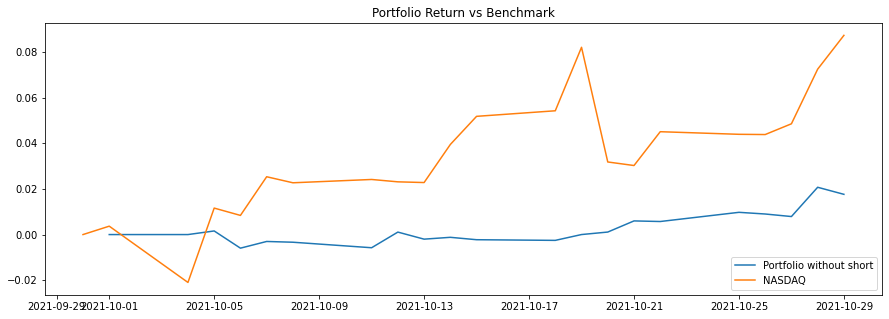

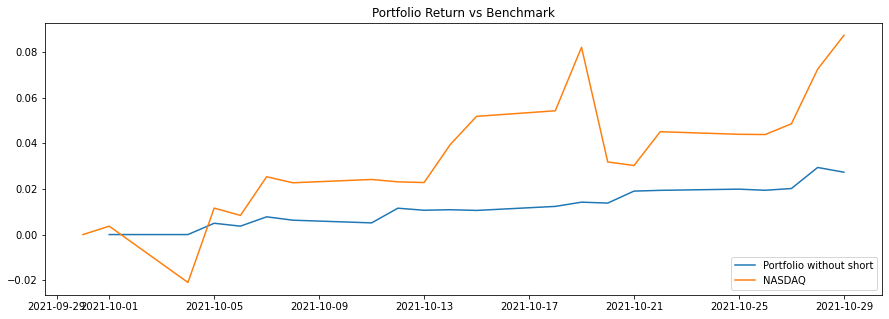

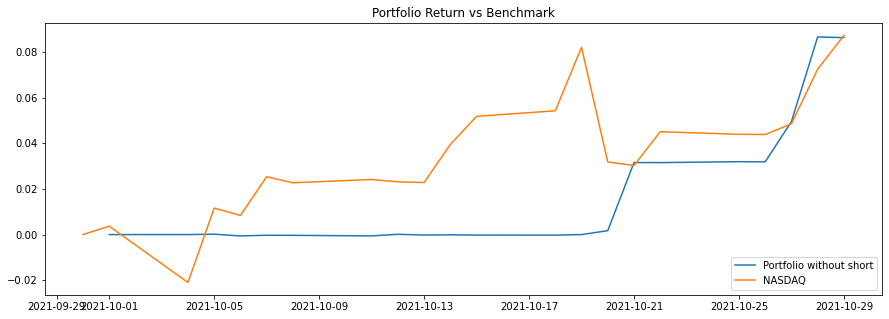

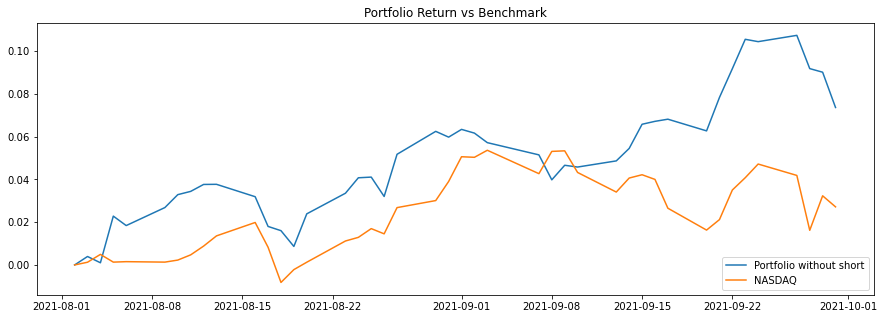

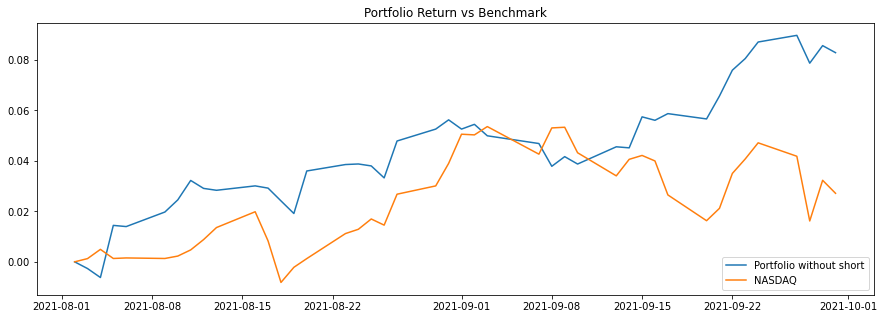

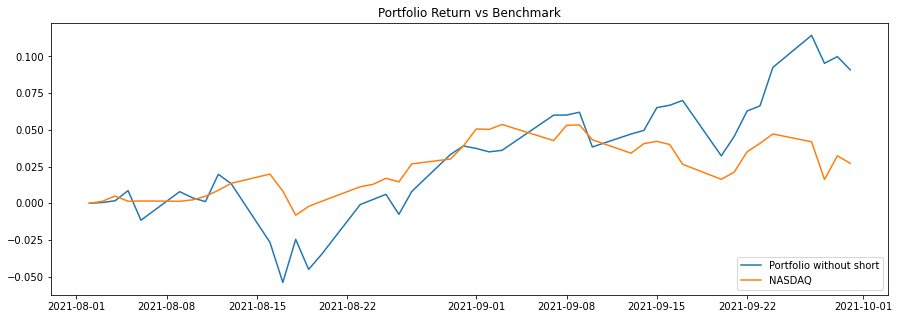

In [59]:
print('Oct:\n')
btest(port_df)
print('Val:\n')
btest(port_df_val)